### 以下代码展示了一个简单的高斯过程模型.虽然只有几行的代码，但动动手可以探索一下高斯过程的优秀吧。

In [1]:
# Xiaoqing Tang 
# 25/04/2020
import numpy as np
import matplotlib.pyplot as plt

### 核函数
demo用了一个高斯核函数：

$k(\mathbf{x}^i,\mathbf{x}^j) = \sigma_f^2 exp\big{(}-\frac{1}{2}\sum \limits_{d=1}^D(x^i_d-x^i_d)\big{/}l_d^2\big{)}$

python中写为
k(x1,x2) = sigma_f\*\*2 * np.exp(-0.5 * np.sum(((x1-x2)/ell)\*\*2))


使用 NxD 和 MxD 矩阵得到 NxM 的核值矩阵。

rbf_fn为单元带宽一定的RBF核

然后gauss_kernel_fn 利用 ell (1xD or 1x1) 和 sigma_f (1x1) 重新调整了rbf核的范围

In [2]:
# np.random.seed(100)
######################################################################

rbf_fn = lambda X1, X2: \
        np.exp((np.dot(X1,(2*X2.T))-np.sum(X1*X1,1)[:,None]) - np.sum(X2*X2,1)[None,:])
gauss_kernel_fn = lambda X1, X2, ell, sigma_f: \
        sigma_f**2 * rbf_fn(X1/(np.sqrt(2)*ell), X2/(np.sqrt(2)*ell))

# 以上代码需要选择一些特定参数，比如：
k_fn = lambda X1, X2: gauss_kernel_fn(X1, X2, 3, 10)

# 或者，玩儿起来:
# k_fn = lambda X1, X2: gauss_kernel_fn(X1, X2, 0.5, 1.0)
# k_fn = lambda X1, X2: gauss_kernel_fn(X1, X2, 0.5, 1.0) + gauss_kernel_fn(X1, X2, 3.0, 10.0)
# ...

In [3]:
# 如果看lambda表达式比较困难，其实gauss_kernel_fn 就是下面这串代码，只不过运行慢点：
def gauss_kernel_naive(X1, X2, ell, sigma_f):
    N, M = X1.shape[0], X2.shape[0]
    K = np.zeros((N, M))
    for n in range(N):
        for m in range(M):
            K[n,m] = sigma_f**2 * np.exp(
                    -0.5*np.sum(((X1[n,:]-X2[m,:])/ell)**2))
    return K

### 从先验分布中采样

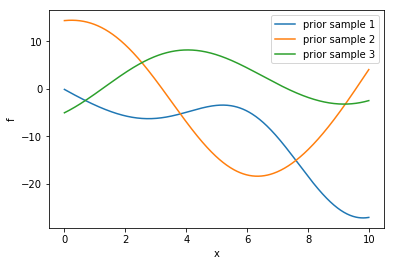

In [4]:

# Pick一些输入值，之后会用到他们的函数值
X_grid = np.arange(0, 10, 0.02)[:,None]

#计算这些点的协方差。理论上高斯核一定会给出正定矩阵。
#现实是残酷的，由于精度问题，实现的时候还是需要加一点点点小噪音(比如 "jitter" 或者 "nugget" 项)

N_grid = X_grid.shape[0]
K_grid = k_fn(X_grid, X_grid) + 1e-9*np.eye(N_grid)
# To sample from Gausian with covariance K=L*L',
# we just multiply L by a vector standard normals:
L_grid = np.linalg.cholesky(K_grid)
plt.figure(1)
plt.clf()
for ii in range(3):
    f_grid = np.dot(L_grid, np.random.randn(N_grid))
    plt.plot(X_grid, f_grid, '-')

plt.legend(['prior sample 1', 'prior sample 2', 'prior sample 3'])
plt.xlabel('x')
plt.ylabel('f')
plt.show()


### 两步法从先验中选择观测点

我们不需和上面一样采样 完整 的函数，或者一个很密集的网络点

选择四个观测点，只采样这四个点并且用叉表示


In [5]:
######################################################################

idx = np.round(N_grid*np.array([0.2,0.4,0.6,0.8])).astype(int)
X_locs1 = X_grid[idx, :]
N_locs1 = idx.size
K_locs1 = k_fn(X_locs1, X_locs1)
L_locs1 = np.linalg.cholesky(K_locs1)

noise_var = 0.1 # add no noise to the samples, we want to look at function values
# noise_var = 1.0 # add some noise to the samples, we want to simulate data
f_locs1 = np.dot(L_locs1, np.random.randn(N_locs1)) + \
        np.sqrt(noise_var)*np.random.randn(N_locs1)
# plt.figure(2)
# plt.clf()
# plt.plot(X_locs1, f_locs1, 'x', markersize=20, markeredgewidth=2)
# plt.show()

### 根据观测值计算后验分布

我们可以选择任何位置的值。

基于选择点，利用标准方程得到其余位置值的高斯分布均值和协方差。

In [6]:
X_rest = np.delete(X_grid, idx, 0)
K_rest = k_fn(X_rest, X_rest)
K_rest_locs1 = k_fn(X_rest, X_locs1)
M = K_locs1 + noise_var*np.eye(N_locs1)
# 一个trick，我们可以计算一次cholesky(M)来解决线性规划问题，哈哈哈，两行解决
rest_cond_mu = np.dot(K_rest_locs1, np.linalg.solve(M, f_locs1))
rest_cond_cov = K_rest - np.dot(K_rest_locs1, np.linalg.solve(M, K_rest_locs1.T))

### 从后验分布中采样
然后要采样三个完整的f_locs1函数。
每个线都是第一步先验中的元素，但是我们和第一步随机采样不同，我们是通过后验方式采样的
这个后验分布是根据我们选择观测点（likelhood）得到的。

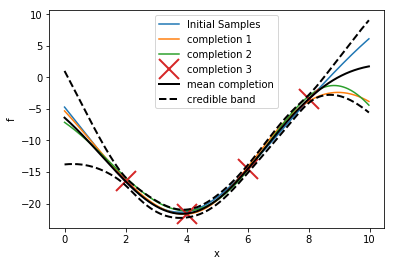

In [7]:

N_rest = X_rest.shape[0]
L_rest = np.linalg.cholesky(rest_cond_cov + 1e-9*np.eye(N_rest))
for ii in range(3):
    rest_sample = np.dot(L_rest, np.random.randn(N_rest)) + rest_cond_mu
    plt.plot(X_rest, rest_sample, '-')

# 如果把上面noise_var从0.0改为1.0，就会得到一个在有噪音的观测条件下的后验条件分布

# 上面的代码是后验分布中sample出几条线打印，而以下代码将会打印后验分布均值和error bar
# 粗实线代表均值，虚线代表 +/- 2标准差范围，意味着在虚线范围内的函数置信度大约有95%。至于为啥是95%你猜呀……
# 哈哈，去回顾一下高斯函数的标准差范围内的pdf积分吧。

#把叉叉画回来
plt.plot(X_locs1, f_locs1, 'x', markersize=20, markeredgewidth=2) 

plt.plot(X_rest, rest_cond_mu, '-k', linewidth=2)
rest_cond_std = np.sqrt(np.diag(rest_cond_cov))
plt.plot(X_rest, rest_cond_mu + 2*rest_cond_std, '--k', linewidth=2)
plt.plot(X_rest, rest_cond_mu - 2*rest_cond_std, '--k', linewidth=2)
# The mean and error bars can be computed more cheaply if you don't want to know
# the whole posterior. See the notes.

plt.legend(['Initial Samples', 'completion 1', 'completion 2', 'completion 3',
        'mean completion', 'credible band'])
plt.xlabel('x')
plt.ylabel('f')
plt.show()